In [1]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory # type: ignore
from tensorflow.keras import layers # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input # type: ignore
from tensorflow.keras.models import Sequential, Model, load_model # type: ignore
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau # type: ignore
from tensorflow.keras.regularizers import l2 # type: ignore

import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Paths
train_dir = "processed_data/train"
val_dir = "processed_data/val"
test_dir = "processed_data/test"

# Settings
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_INITIAL = 10
EPOCHS_FINE_TUNE = 10

# Load datasets
train_ds = image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

test_ds = image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Class names and number of classes
class_names = train_ds.class_names
num_classes = len(class_names)

# Cache & prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE #Preface
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 7677 files belonging to 96 classes.
Found 957 files belonging to 96 classes.
Found 963 files belonging to 96 classes.


In [4]:
MIXUP_P = 0.3
MIXUP_ALPHA = 0.2

def sample_beta(alpha):
    a = tf.random.gamma([1], alpha)
    b = tf.random.gamma([1], alpha)
    return a / (a + b)  # shape [1], float32

def do_mixup(images, labels):
    bs = tf.shape(images)[0]
    lam = tf.cast(sample_beta(MIXUP_ALPHA), tf.float32)  # [1]
    lam = tf.reshape(lam, [])  # scalar
    idx = tf.random.shuffle(tf.range(bs))
    images2 = tf.gather(images, idx)
    labels2 = tf.gather(labels, idx)
    mixed_images = lam * images + (1.0 - lam) * images2
    mixed_labels = lam * labels + (1.0 - lam) * labels2
    return mixed_images, mixed_labels

def maybe_mixup(images, labels):
    r = tf.random.uniform([])
    return tf.cond(r < MIXUP_P,
                   lambda: do_mixup(images, labels),
                   lambda: (images, labels))

# assuming train_ds yields (images, integer_labels)
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(tf.cast(y, tf.int32), num_classes)),
                        num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(maybe_mixup, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(tf.cast(y, tf.int32), num_classes)))\
               .prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (x, tf.one_hot(tf.cast(y, tf.int32), num_classes)))\
                 .prefetch(tf.data.AUTOTUNE)

Epoch 1/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 562s 2s/step - accuracy: 0.0663 - loss: 4.5695 - val_accuracy: 0.2623 - val_loss: 3.2805
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 522s 2s/step - accuracy: 0.2216 - loss: 3.5349 - val_accuracy: 0.3156 - val_loss: 2.9254
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 543s 2s/step - accuracy: 0.3064 - loss: 3.2074 - val_accuracy: 0.3699 - val_loss: 2.7256
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 525s 2s/step - accuracy: 0.3573 - loss: 2.9517 - val_accuracy: 0.3804 - val_loss: 2.6909
Epoch 5/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 489s 2s/step - accuracy: 0.3708 - loss: 2.8492 - val_accuracy: 0.3960 - val_loss: 2.6317
Epoch 6/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 494s 2s/step - accuracy: 0.3760 - loss: 2.8699 - val_accuracy: 0.4180 - val_loss: 2.5667
Epoch 7/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 439s 2s/step - accuracy: 0.4189 - loss: 2.6845 - val_accuracy: 0.4295 - val_loss: 2.5462
Epoch 8/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 497s 2s/step - accuracy: 0.4188 - loss: 2.6340 - val_accu

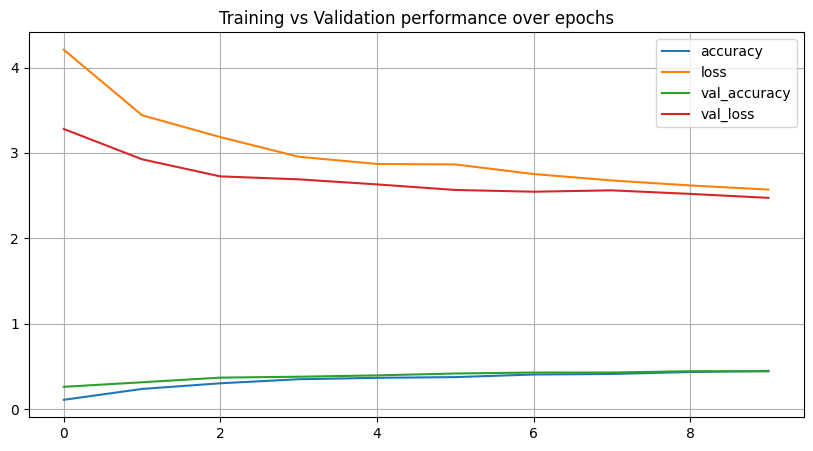

31/31 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.4404 - loss: 2.4332
Test accuracy: 44%


In [4]:
# Apply data augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    # layers.RandomContrast(0.2),
    layers.RandomTranslation(0.1, 0.1),
    # layers.RandomBrightness(0.2),
])

# Base model
base_model = EfficientNetB0(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # Freeze base

# Model architecture
inputs = layers.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, kernel_regularizer=l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(x)

model = Model(inputs, outputs)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ModelCheckpoint(filepath='best_frozen.keras', monitor='val_accuracy', save_best_only=True),
]

# Initial training
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs= EPOCHS_INITIAL,
    callbacks=callbacks
)

# Save best model
model.save('best_frozen.keras')

# Visualize performance
pd.DataFrame(history.history).plot(figsize=(10, 5))
plt.title('Training vs Validation performance over epochs')
plt.grid(True)
plt.show()

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc * 100:.0f}%")

In [ ]:
def fine_tune(model_path, freeze_ratio, new_ckpt, lr, epochs, initial_epoch):
    model = load_model(model_path)

    # Locate the base model (EfficientNet)
    base_model = None
    for layer in model.layers:
        if "efficientnet" in layer.name:
            base_model = layer
            break
                
    if base_model is None:
        raise ValueError("Base model (EfficientNet) not found in the loaded model!")

    base_model.trainable = True
    num_layers = len(base_model.layers)
    fine_tune_at = int(num_layers * freeze_ratio)

    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint(filepath=new_ckpt, monitor='val_accuracy', save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
    ]

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        initial_epoch=initial_epoch,
        callbacks=callbacks
    )

    return model, history


# Fine-tuning 1: Unfreeze top 20% of layers
model, history_finetune_20 = fine_tune(
    model_path='best_frozen.keras',
    freeze_ratio=0.8, # freeze bottom 80%
    new_ckpt='best_finetune_20.keras',
    lr=1e-4,
    epochs=EPOCHS_FINE_TUNE + EPOCHS_INITIAL,
    initial_epoch=history.epoch[-1]
)

pd.DataFrame(history_finetune_20.history).plot(figsize=(10, 5))
plt.title('Training vs Validation performance over epochs')
plt.grid(True)
plt.show()

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc * 100:.0f}%")

# Fine-tuning 2: Unfreeze top 40% of layers
model, history_finetune_40 = fine_tune(
    model_path='best_finetune_20.keras',
    freeze_ratio=0.6, # freeze bottom 60%
    new_ckpt='best_finetune_40.keras',
    lr=1e-4,
    epochs=2*EPOCHS_FINE_TUNE + EPOCHS_INITIAL,
    initial_epoch=history_finetune_20.epoch[-1]
)

pd.DataFrame(history_finetune_40.history).plot(figsize=(10, 5))
plt.title('Training vs Validation performance over epochs')
plt.grid(True)
plt.show()

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc * 100:.0f}%")

# Fine-tuning 3: Unfreeze top 50% of layers
model, history_finetune_50 = fine_tune(
    model_path='best_finetune_40.keras',
    freeze_ratio=0.5, # freeze bottom 50%
    new_ckpt='best_finetune_50.keras',
    lr=1e-5,
    epochs=3*EPOCHS_FINE_TUNE + EPOCHS_INITIAL,
    initial_epoch=history_finetune_40.epoch[-1]
)

pd.DataFrame(history_finetune_50.history).plot(figsize=(10, 5))
plt.title('Training vs Validation performance over epochs')
plt.grid(True)
plt.show()

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc * 100:.0f}%")

# Fine-tuning 4: Unfreeze top 60% of layers
model, history_finetune_60 = fine_tune(
    model_path='best_finetune_50.keras',
    freeze_ratio=0.4, # freeze bottom 40%
    new_ckpt='best_finetune_60.keras',
    lr=1e-5,
    epochs=4*EPOCHS_FINE_TUNE + EPOCHS_INITIAL,
    initial_epoch=history_finetune_50.epoch[-1]
)

pd.DataFrame(history_finetune_60.history).plot(figsize=(10, 5))
plt.title('Training vs Validation performance over epochs')
plt.grid(True)
plt.show()

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc * 100:.0f}%")

Epoch 10/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 611s 2s/step - accuracy: 0.3203 - loss: 3.1454 - val_accuracy: 0.4535 - val_loss: 2.4946 - learning_rate: 1.0000e-04
Epoch 11/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 550s 2s/step - accuracy: 0.4566 - loss: 2.5042 - val_accuracy: 0.4817 - val_loss: 2.4442 - learning_rate: 1.0000e-04
Epoch 12/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 569s 2s/step - accuracy: 0.5201 - loss: 2.2689 - val_accuracy: 0.4859 - val_loss: 2.3584 - learning_rate: 1.0000e-04
Epoch 13/20
136/240 ━━━━━━━━━━━━━━━━━━━━ 4:27 3s/step - accuracy: 0.5549 - loss: 2.1789

In [5]:
model = load_model(r"colab\best_finetune_60.keras")

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc * 100:.0f}%")

31/31 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.5761 - loss: 2.0430
Test accuracy: 60%
